# Part 2
## Contents

1. [libraries and files](#libraries)
2. [Importing data](#import)
3. [Viewing the class in balance](#inbalance)
4. [What I am doing](#stuff)
5. [KNN](#KNN)
    1. [Conclusions](#knn_con)
6. [Decision Tree](#dt)
    1. [Conclusions](#tree_con)
7. [Bagging](#bagging)
    1. [Conclusion](#bagging_con)
    


## Libraries
<a id='libraries'></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold #Something to split and randomise the data 

from sklearn.neighbors import KNeighborsClassifier #Importing knn model

from sklearn import ensemble
from sklearn.tree import DecisionTreeClassifier

from sklearn import tree


from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score


from sklearn import linear_model
from sklearn.svm import SVC

from sklearn.ensemble import BaggingClassifier


## Importing data and sorting them
<a id='import'></a>

In [2]:
data = pd.read_csv('Credit/creditdefault_train.csv') #Putting the test data and the train data in data frames 
test = pd.read_csv('Credit/creditdefault_test.csv')

#Seperating the train data labels from the inputs:
y_train = data['Y']
x_train = data.drop(['Y'],axis=1)

#Seperating the test data labels from the inputs:
y_test = test['Y']
x_test = test.drop(['Y'],axis=1)

kf = StratifiedKFold(n_splits=3)
#kf = KFold(15000, n_folds=3)



## Viewing the class in balance
<a id='libraries'></a>

In [3]:
def inbalance(y,classes):
    '''A function that displays the difference in classes in bar graph form'''
    num_classes = np.zeros(len(classes)) # A place to tally all the classes
    for i in range(len(y)):
        num_classes[y[i]] += 1
        
    for i in range(len(classes)):
        print('The total number in class ' + classes[i] + ' is ' + str(num_classes[i]))
    plt.bar(x=classes,height=num_classes) # plotting bar graph
    

### Train data

The total number in class No is 11682.0
The total number in class Yes is 3318.0


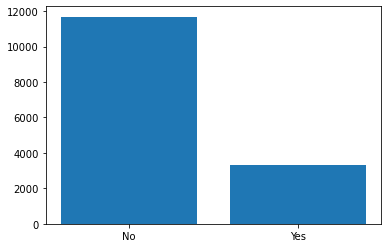

In [4]:
inbalance(y_train,['No','Yes'])

### Test data 

The total number in class No is 11682.0
The total number in class Yes is 3318.0
15000


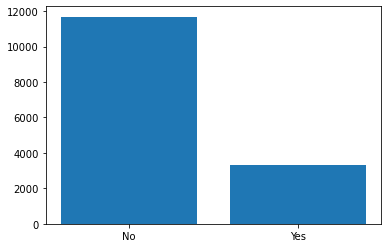

In [5]:
inbalance(y_test,['No','Yes'])
print(len(y_test))

### Conclusions
Because the data has a large class inbalance the metrics used will be sensitive to defualts rather than payments which means I will use precision with respect to each class but with a focus on defaulters because there is less of them

### What I am doing
<a id='stuff'></a>
The way I will explore any model is first by spliting the test data into 3 folds. 2 folds (temp_test_x/y) will be used to test and the last fold will be excluded. This every version of this will be fitted and tested and the acc precision for both classes will be stored and then the mean of the outputs will be the train metrics. The next step  is that the whole training set will be put into the same model and the test data set will be predicted and then the output will be measured and visualised. 

In [6]:
def visualise(train_acc,train_d,train_p,test_acc,test_d,test_p,dependant_var,dependant_label):
    """Visualisation of train/test accuracy and precision"""
    fig,axs = plt.subplots(3,1,figsize=(12,6))
    
    print(test_acc)
    print(test_d)
    print(test_p)
    
    
    axs[0].plot(dependant_var,train_acc,'ro-',dependant_var,test_acc,'bv--')
    axs[0].legend(['Training Accuracy','Test Accuracy'])
    axs[0].set_xlabel(dependant_label)
    axs[0].set_ylabel('Accuracy')
    
    axs[1].plot(dependant_var,train_d,'ro-',dependant_var,test_d,'bv--')
    axs[1].legend(['Training default precision','Test default precision'])
    axs[1].set_xlabel(dependant_label)
    axs[1].set_ylabel('Default precision')
    
    axs[2].plot(dependant_var,train_p,'ro-',dependant_var,test_p,'bv--')
    axs[2].legend(['Training payment precision','Test payment precision'])
    axs[2].set_xlabel(dependant_label)
    axs[2].set_ylabel('payment precision')
    

## KNN
<a id='KNN'></a>

### Building Generic model

In [7]:
def knn(neig,met='euclidean',q=2):   
    train_metrics_mean = np.zeros(3) #Place to store the mean of accuracy, defualt and payment precision 
    

    train_metrics = np.zeros((3,3)) #3x3 matrix to store current train accuracy 
    
    test_metrics = np.zeros(3)  #Place to store test accuracy of that model

    counter = 0
    for train_index, test_index in kf.split(x_train,y_train):# Splitting into three folds 

        #Taking the elements and putting them into array:
        temp_train_x = np.take(x_train,train_index,0)
        temp_train_y = np.take(y_train,train_index,0)

        temp_test_x = np.take(x_train,test_index,0)
        temp_test_y = np.take(y_train,test_index,0)

        #Building model
        if(met == 'minkowski'):
            knn = KNeighborsClassifier(n_neighbors=neig,metric=met,p=q,n_jobs=-2)
        
        else:
            knn = KNeighborsClassifier(n_neighbors=neig,metric=met,n_jobs=-2)
        
        #Fitting model
        knn.fit(temp_train_x,temp_train_y)
        #Creating predictions
        pred = knn.predict(temp_train_x)
        
        #Storing the metrics of current fold
        train_metrics[counter][0] = accuracy_score(pred,temp_train_y)
        train_metrics[counter][1] = precision_score(pred,temp_train_y)
        train_metrics[counter][2] = precision_score(pred,temp_train_y,pos_label=0)
        
        counter+=1
    
    #Working out the mean of the outputs
    train_metrics_mean = np.mean(train_metrics,axis=0)  ## Working out the mean
    
    #Tesing on the full data set and test set
    if(met == 'minkowski'):
        main_knn = KNeighborsClassifier(n_neighbors=neig,metric=met,p=q,n_jobs=-2)
    else:
        main_knn = KNeighborsClassifier(n_neighbors=neig,metric=met,n_jobs=-2)
        
    main_knn.fit(x_train,y_train)
    
    prediction = main_knn.predict(x_test)
    #Storing the metrics on test set
    test_metrics[0] = accuracy_score(prediction,y_test)
    test_metrics[1] = precision_score(prediction,y_test)
    test_metrics[2] = precision_score(prediction,y_test,pos_label=0)
    
    return (train_metrics_mean,test_metrics) #Returning two arrays filled with elements
    
    

### Manhattan

In [8]:
#Places to store the metrics to judge by:
train_manhattan_acc = []  #Train accuracy score 
train_manhattan_d = []    #Train Default precision
train_manhattan_p = []    #Train payment precision


test_manhattan_acc = []    #Test accuracy score 
test_manhattan_d = []      #Test default precision
test_manhattan_p = []      #Test Payment precison



In [9]:
for i in range(1,31): #Going through 1-30 neigbours
    train,test = knn(i) #Building the model with different hyperparameters

    #Storing the elements in the different arrays:
    #Train elements
    train_manhattan_acc.append(train[0])
    train_manhattan_d.append(train[1])
    train_manhattan_p.append(train[2])
    
    #Test elements
    test_manhattan_acc.append(test[0])
    test_manhattan_d.append(test[1])
    test_manhattan_p.append(test[2])

[0.6913333333333334, 0.7639333333333334, 0.734, 0.7664, 0.7518, 0.7682666666666667, 0.759, 0.7729333333333334, 0.7652, 0.7741333333333333, 0.7687333333333334, 0.7738666666666667, 0.7689333333333334, 0.7739333333333334, 0.7708, 0.7747333333333334, 0.7719333333333334, 0.7755333333333333, 0.7744666666666666, 0.7755333333333333, 0.7741333333333333, 0.7757333333333334, 0.7752, 0.7768666666666667, 0.7752, 0.7774, 0.777, 0.7778, 0.7780666666666667, 0.7784666666666666]
[0.29053646775165765, 0.1057866184448463, 0.22965641952983726, 0.1106088004822182, 0.1844484629294756, 0.09825195901145269, 0.15220012055455093, 0.0970464135021097, 0.13562386980108498, 0.09252561784207354, 0.12356841470765521, 0.08348402652200121, 0.1112115732368897, 0.08288125376732972, 0.10548523206751055, 0.07685352622061482, 0.09885473176612417, 0.07142857142857142, 0.09403254972875226, 0.07082579867389995, 0.0861965039180229, 0.06811332127787824, 0.08468957203134418, 0.0650994575045208, 0.07685352622061482, 0.0617842073538

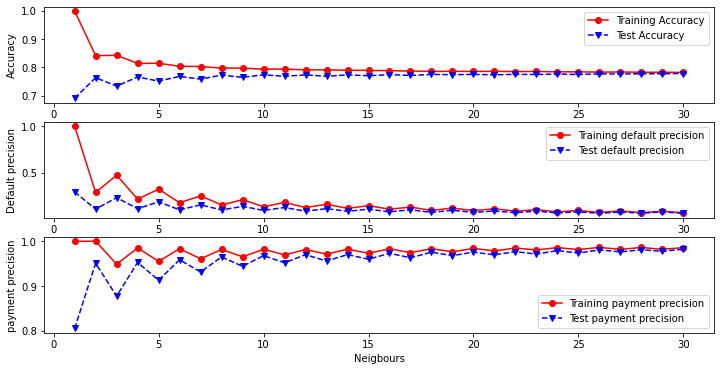

In [10]:
visualise(train_manhattan_acc,train_manhattan_d,train_manhattan_p,
          test_manhattan_acc,test_manhattan_d,test_manhattan_p,range(1,31),'Neigbours')

### Euclidean

In [11]:
#Places to store the metrics to judge by:
train_euclidean_acc = []  #Train accuracy score 
train_euclidean_d = []    #Train Default precision
train_euclidean_p = []    #Train payment precision


test_euclidean_acc = []    #Test accuracy score 
test_euclidean_d = []      #Test default precision
test_euclidean_p = []      #Test Payment precison


In [12]:
for i in range(1,31): #Going through 1-30 neigbours
    train,test = knn(i,'euclidean') #Building the model with different hyperparameters

    #Storing the elements in the different arrays:
    #Train elements
    train_euclidean_acc.append(train[0])
    train_euclidean_d.append(train[1])
    train_euclidean_p.append(train[2])
    
    #Test elements
    test_euclidean_acc.append(test[0])
    test_euclidean_d.append(test[1])
    test_euclidean_p.append(test[2])

[0.6913333333333334, 0.7639333333333334, 0.734, 0.7664, 0.7518, 0.7682666666666667, 0.759, 0.7729333333333334, 0.7652, 0.7741333333333333, 0.7687333333333334, 0.7738666666666667, 0.7689333333333334, 0.7739333333333334, 0.7708, 0.7747333333333334, 0.7719333333333334, 0.7755333333333333, 0.7744666666666666, 0.7755333333333333, 0.7741333333333333, 0.7757333333333334, 0.7752, 0.7768666666666667, 0.7752, 0.7774, 0.777, 0.7778, 0.7780666666666667, 0.7784666666666666]
[0.29053646775165765, 0.1057866184448463, 0.22965641952983726, 0.1106088004822182, 0.1844484629294756, 0.09825195901145269, 0.15220012055455093, 0.0970464135021097, 0.13562386980108498, 0.09252561784207354, 0.12356841470765521, 0.08348402652200121, 0.1112115732368897, 0.08288125376732972, 0.10548523206751055, 0.07685352622061482, 0.09885473176612417, 0.07142857142857142, 0.09403254972875226, 0.07082579867389995, 0.0861965039180229, 0.06811332127787824, 0.08468957203134418, 0.0650994575045208, 0.07685352622061482, 0.0617842073538

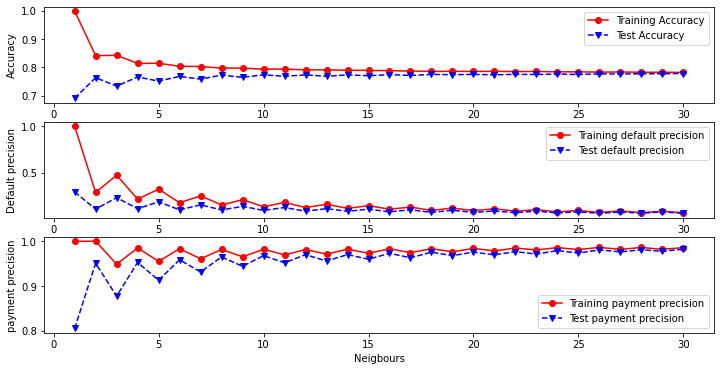

In [13]:
visualise(train_euclidean_acc,train_euclidean_d,train_euclidean_p,
          test_euclidean_acc,test_euclidean_d,test_euclidean_p,range(1,31),'Neigbours')

### Minkowski

In [14]:
def minkow(q):
    '''Function to work out the minkowski output of knn varing p'''
    #Places to store the metrics to judge by:
    train_mink_acc = []  #Train accuracy score 
    train_mink_d = []    #Train Default precision
    train_mink_p = []    #Train payment precision


    test_mink_acc = []    #Test accuracy score 
    test_mink_d = []      #Test default precision
    test_mink_p = []      #Test Payment precison

    for i in range(1,31): #Going through 1-30 neigbours
        train,test = knn(i,'minkowski',q) #Building the model with different hyperparameters

        #Storing the elements in the different arrays:
        #Train elements
        train_mink_acc.append(train[0])
        train_mink_d.append(train[1])
        train_mink_p.append(train[2])

        #Test elements
        test_mink_acc.append(test[0])
        test_mink_d.append(test[1])
        test_mink_p.append(test[2])

    visualise(train_mink_acc,train_mink_d,train_mink_p,
              test_mink_acc,test_mink_d,test_mink_p,range(1,31),'Neigbours')
    



#### Minkowski (1,5,10,15,20)

[0.6908, 0.7640666666666667, 0.7341333333333333, 0.7674666666666666, 0.7534, 0.7713333333333333, 0.7606666666666667, 0.7741333333333333, 0.7686666666666667, 0.7765333333333333, 0.7707333333333334, 0.7752666666666667, 0.7705333333333333, 0.7752666666666667, 0.7728666666666667, 0.7762666666666667, 0.7720666666666667, 0.7770666666666667, 0.7756666666666666, 0.7780666666666667, 0.7758, 0.7778, 0.7768, 0.7775333333333333, 0.7772666666666667, 0.7777333333333334, 0.7769333333333334, 0.778, 0.7774666666666666, 0.7784666666666666]
[0.29475587703435807, 0.11181434599156118, 0.23176612417118747, 0.12025316455696203, 0.19077757685352623, 0.10759493670886076, 0.16003616636528029, 0.10337552742616034, 0.14948764315852922, 0.09915611814345991, 0.13050030138637733, 0.09011452682338758, 0.11904761904761904, 0.09282700421940929, 0.11995177817962628, 0.08649789029535865, 0.10970464135021098, 0.08107293550331525, 0.10216998191681737, 0.08016877637130802, 0.09734779987944545, 0.07805907172995781, 0.0907172

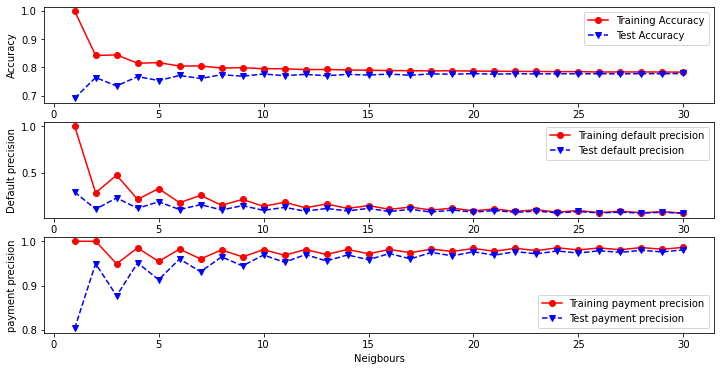

In [15]:
minkow(1)

[0.6900666666666667, 0.76, 0.73, 0.7646666666666667, 0.7489333333333333, 0.7675333333333333, 0.7555333333333333, 0.7708, 0.7624666666666666, 0.7724666666666666, 0.7666666666666667, 0.7728, 0.7697333333333334, 0.7735333333333333, 0.7708666666666667, 0.7749333333333334, 0.7713333333333333, 0.7748666666666667, 0.7728666666666667, 0.7752, 0.7734666666666666, 0.776, 0.7742, 0.7774, 0.7764, 0.778, 0.7760666666666667, 0.7776, 0.7762666666666667, 0.7776666666666666]
[0.2938517179023508, 0.10126582278481013, 0.22332730560578662, 0.1051838456901748, 0.17992766726943943, 0.09915611814345991, 0.15009041591320071, 0.09282700421940929, 0.13411693791440626, 0.09101868595539482, 0.12386980108499096, 0.08468957203134418, 0.11332127787823991, 0.08197709463532249, 0.10669077757685352, 0.07866184448462929, 0.10006027727546715, 0.06931886678722121, 0.09192284508740205, 0.06841470765521399, 0.08710066305003014, 0.06660638939119952, 0.07986738999397228, 0.06419529837251356, 0.08047016274864376, 0.06570223025

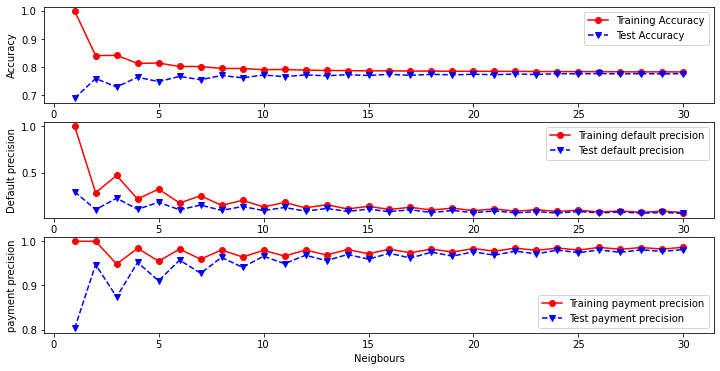

In [16]:
minkow(5)

[0.6892, 0.7602, 0.7299333333333333, 0.7632666666666666, 0.7469333333333333, 0.7671333333333333, 0.7542666666666666, 0.7704666666666666, 0.7614666666666666, 0.7720666666666667, 0.766, 0.7739333333333334, 0.7691333333333333, 0.7736, 0.7709333333333334, 0.7742, 0.7708, 0.7748, 0.7714666666666666, 0.7739333333333334, 0.7723333333333333, 0.7754666666666666, 0.7743333333333333, 0.7779333333333334, 0.7764666666666666, 0.7778, 0.7764666666666666, 0.7770666666666667, 0.7764666666666666, 0.7772666666666667]
[0.2962628089210368, 0.1024713682941531, 0.22483423749246534, 0.10156720916214587, 0.17872212176009644, 0.10126582278481013, 0.15732368896925858, 0.09403254972875226, 0.13682941531042797, 0.08951175406871609, 0.12236286919831224, 0.08649789029535865, 0.1160337552742616, 0.081374321880651, 0.10849909584086799, 0.07805907172995781, 0.09915611814345991, 0.07655213984327909, 0.09373116335141651, 0.0699216395418927, 0.08499095840867993, 0.06479807112718505, 0.08257986738999397, 0.0669077757685352

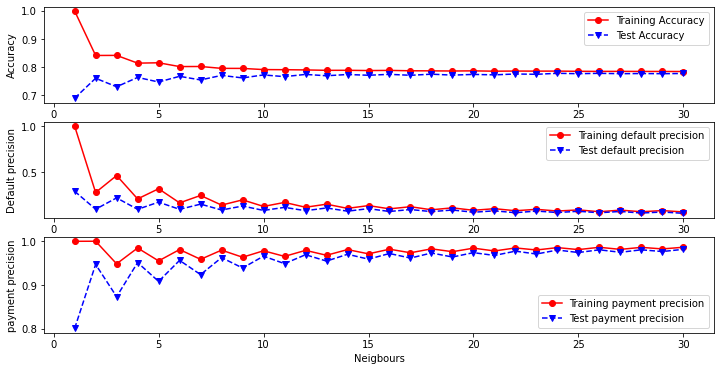

In [17]:
minkow(10)

[0.6887333333333333, 0.7594, 0.7288, 0.7637333333333334, 0.7475333333333334, 0.7683333333333333, 0.7548666666666667, 0.7714, 0.7625333333333333, 0.7718666666666667, 0.767, 0.7739333333333334, 0.7684666666666666, 0.7733333333333333, 0.7712666666666667, 0.7749333333333334, 0.772, 0.7748, 0.7723333333333333, 0.7744, 0.7721333333333333, 0.7758, 0.7749333333333334, 0.7776666666666666, 0.776, 0.7776666666666666, 0.7754666666666666, 0.7769333333333334, 0.7766, 0.7774666666666666]
[0.30018083182640143, 0.10307414104882459, 0.2239300783604581, 0.10307414104882459, 0.18053044002411092, 0.10548523206751055, 0.15581675708257986, 0.09523809523809523, 0.13954189270644968, 0.08890898131404461, 0.12176009644364075, 0.0867992766726944, 0.11452682338758288, 0.08318264014466546, 0.11091018685955395, 0.07805907172995781, 0.1003616636528029, 0.07655213984327909, 0.0949367088607595, 0.07022302591922845, 0.08559373116335142, 0.06540084388185655, 0.08288125376732972, 0.06811332127787824, 0.07986738999397228, 

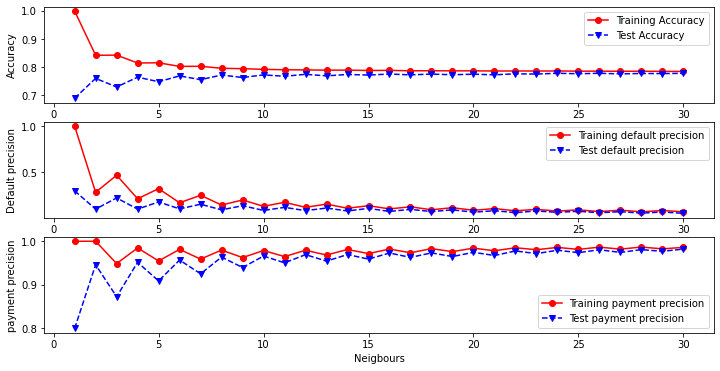

In [18]:
minkow(15)

[0.6886666666666666, 0.7596666666666667, 0.728, 0.7638666666666667, 0.7482666666666666, 0.7678, 0.7557333333333334, 0.7714, 0.7632666666666666, 0.7715333333333333, 0.7677333333333334, 0.7736666666666666, 0.768, 0.7734666666666666, 0.771, 0.7748666666666667, 0.7716, 0.7750666666666667, 0.7721333333333333, 0.7748666666666667, 0.773, 0.7752, 0.7743333333333333, 0.777, 0.7758, 0.7777333333333334, 0.7756666666666666, 0.7772666666666667, 0.7762, 0.7774]
[0.3004822182037372, 0.10458107293550331, 0.22151898734177214, 0.10337552742616034, 0.1811332127787824, 0.10337552742616034, 0.15792646172393007, 0.09463532248342375, 0.14135021097046413, 0.08890898131404461, 0.12507534659433395, 0.08710066305003014, 0.1160337552742616, 0.08408679927667269, 0.11000602772754671, 0.07836045810729356, 0.09915611814345991, 0.07564798071127185, 0.09523809523809523, 0.07203134418324292, 0.08800482218203737, 0.06630500301386377, 0.08288125376732972, 0.06720916214587101, 0.0807715491259795, 0.0650994575045208, 0.0777

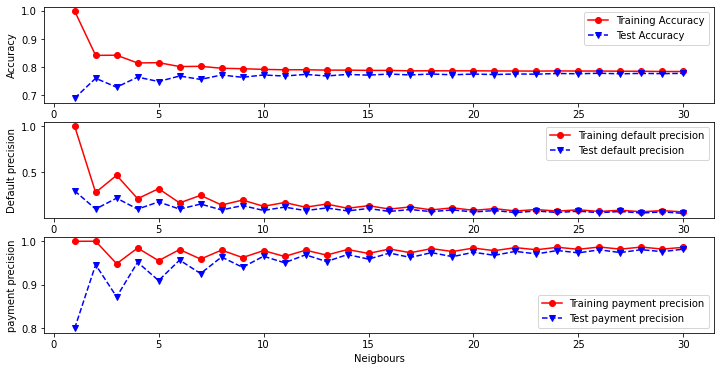

In [19]:
minkow(20)

### Conclusions
<a id='knn_con'></a>

For knn I have realised that the total number of elements in the class payment is 11682 and default is 3318 therefore if I increase the number of neighbouts for precision of defaults the more accurate it would be but after a certain number will be more and more likely that the model will select payment. All the outputs for minkowski, euclidean and manhattan are relatively similar. To pick the best model for knn I must decide the tradeoff between overall accuracy and default precision. Thats why I am selecting KNN euclidean with 5 nearest neighbours


## Decision Tree
<a id='dt'></a>

### Building generic model

In [20]:
def decision(depth,impurity='gini',q=2):   
    train_metrics_mean = np.zeros(3) #Place to store the mean of accuracy, defualt and payment precision 
    

    train_metrics = np.zeros((3,3)) #3x3 matrix to store current train accuracy 
    
    test_metrics = np.zeros(3)  #Place to store test accuracy of that model

    counter = 0
    for train_index, test_index in kf.split(x_train,y_train):# Splitting into three folds 

        #Taking the elements and putting them into array:
        temp_train_x = np.take(x_train,train_index,0)
        temp_train_y = np.take(y_train,train_index,0)

        temp_test_x = np.take(x_train,test_index,0)
        temp_test_y = np.take(y_train,test_index,0)

        #Building model
        dt = tree.DecisionTreeClassifier(criterion=impurity,max_depth=depth,max_features='auto')
        
        #Fitting model
        dt.fit(temp_train_x,temp_train_y)
        #Creating predictions
        pred = dt.predict(temp_train_x)
        
        #Storing the metrics of current fold
        train_metrics[counter][0] = accuracy_score(pred,temp_train_y)
        train_metrics[counter][1] = precision_score(pred,temp_train_y)
        train_metrics[counter][2] = precision_score(pred,temp_train_y,pos_label=0)
        
        counter+=1
    
    #Working out the mean of the outputs
    train_metrics_mean = np.mean(train_metrics,axis=0)  ## Working out the mean
    
    #Tesing on the full data set and test set
    
    main_dt = tree.DecisionTreeClassifier(criterion=impurity,max_depth=depth)#,max_features='auto')
        
    main_dt.fit(x_train,y_train)
    
    prediction = main_dt.predict(x_test)
    #Storing the metrics on test set
    test_metrics[0] = accuracy_score(prediction,y_test)
    test_metrics[1] = precision_score(prediction,y_test)
    test_metrics[2] = precision_score(prediction,y_test,pos_label=0)
    
    return (train_metrics_mean,test_metrics) #Returning two arrays filled with elements
    
    

In [21]:
def treeBuilder(impurity='gini'):
    '''Easy function to develop and build the decision trees as well as visualise the results'''
    #Places to store the metrics to judge by:
    train_acc = []  #Train accuracy score 
    train_d = []    #Train Default precision
    train_p = []    #Train payment precision


    test_acc = []    #Test accuracy score 
    test_d = []      #Test default precision
    test_p = []      #Test Payment precison

    for i in range(2,31): #Going through 1-30 max depth
        train,test = decision(i,impurity) #Building the model with different hyperparameters

        #Storing the elements in the different arrays:
        #Train elements
        train_acc.append(train[0])
        train_d.append(train[1])
        train_p.append(train[2])

        #Test elements
        test_acc.append(test[0])
        test_d.append(test[1])
        test_p.append(test[2])

    visualise(train_acc,train_d,train_p,
              test_acc,test_d,test_p,range(2,31),'depth')

### Gini

[0.8179333333333333, 0.8196666666666667, 0.8172666666666667, 0.8169333333333333, 0.8108666666666666, 0.8125333333333333, 0.8095333333333333, 0.8064, 0.8045333333333333, 0.8018, 0.7960666666666667, 0.7904, 0.7863333333333333, 0.7844666666666666, 0.7753333333333333, 0.7700666666666667, 0.7608, 0.7540666666666667, 0.7512666666666666, 0.7465333333333334, 0.7458666666666667, 0.7422666666666666, 0.7406, 0.7365333333333334, 0.738, 0.7365333333333334, 0.7315333333333334, 0.7305333333333334, 0.7298666666666667]
[0.31856540084388185, 0.3704038577456299, 0.3423749246534057, 0.3215792646172393, 0.36859553948161544, 0.3535262206148282, 0.36467751657625075, 0.377335744424352, 0.3679927667269439, 0.36528028933092227, 0.3884870403857746, 0.35593731163351416, 0.3791440626883665, 0.37884267631103075, 0.37613019891500904, 0.3637733574442435, 0.3866787221217601, 0.38788426763110306, 0.391500904159132, 0.4011452682338758, 0.39783001808318263, 0.41078963230861965, 0.4050632911392405, 0.40174804098854733, 0.

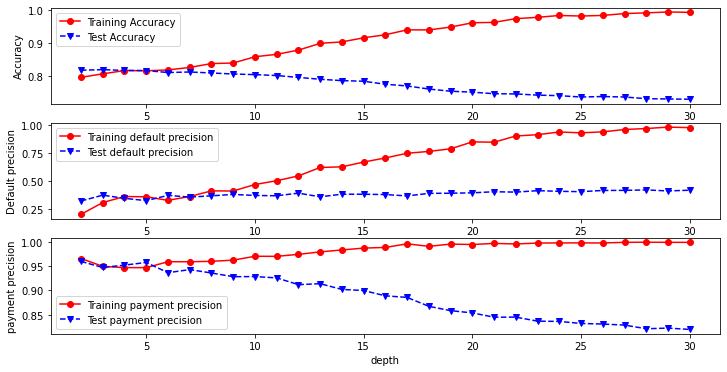

In [22]:
treeBuilder()

### Entropy

[0.8172666666666667, 0.8196666666666667, 0.8182, 0.8168, 0.8158, 0.8152666666666667, 0.8122, 0.8105333333333333, 0.8073333333333333, 0.8054, 0.7992666666666667, 0.7936666666666666, 0.7880666666666667, 0.7838666666666667, 0.7774, 0.7729333333333334, 0.7626, 0.7560666666666667, 0.7505333333333334, 0.7483333333333333, 0.7454666666666667, 0.7428, 0.7364666666666667, 0.7402666666666666, 0.737, 0.7376, 0.739, 0.7380666666666666, 0.733]
[0.32489451476793246, 0.36980108499095843, 0.3547317661241712, 0.31977094635322484, 0.3291139240506329, 0.3203737191078963, 0.32519590114526825, 0.32760699216395417, 0.36467751657625075, 0.352622061482821, 0.352622061482821, 0.352622061482821, 0.36196503918022904, 0.3719107896323086, 0.36738999397227246, 0.3779385171790235, 0.37100663050030136, 0.3896925858951175, 0.36738999397227246, 0.3899939722724533, 0.3845690174804099, 0.39662447257383965, 0.3948161543098252, 0.39933694996986135, 0.39783001808318263, 0.40687160940325495, 0.4077757685352622, 0.405063291139

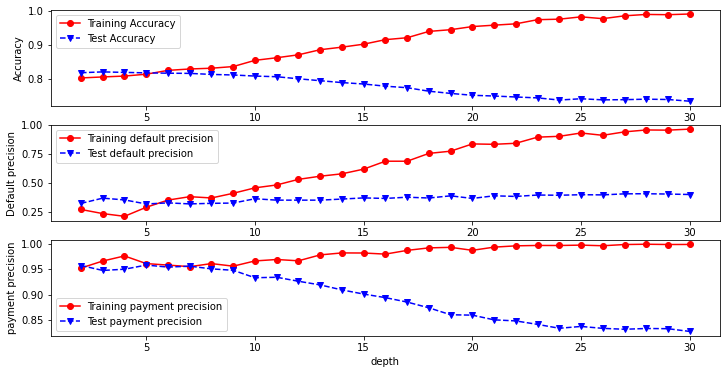

In [23]:
treeBuilder('entropy')

## Conclusions
<a id='tree_con'></a>

My current conclusions are that the more complex the model is the more overfitting is a problem for default is. This is becasue the model is probalbly learning that the it is more than likely that the output would be a payment because the data is imbalaced. This is why I am picking a tree of depth 5 

## Bagging 
<a id='bagging'></a>

In [24]:
def bag(depth, bootstrap_, bootstrap_features, est_, max_feat):   
    '''This function builds a model and runs it on 2/3 of test data and the gets the mean of all cut out thenh runs
    it on full set and tests on test data'''
    
    train_metrics_mean = np.zeros(3) #Place to store the mean of accuracy, defualt and payment precision 
    

    train_metrics = np.zeros((3,3)) #3x3 matrix to store current train accuracy 
    
    test_metrics = np.zeros(3)  #Place to store test accuracy of that model

    counter = 0
    for train_index, test_index in kf.split(x_train,y_train):# Splitting into three folds 

        #Taking the elements and putting them into array:
        temp_train_x = np.take(x_train,train_index,0)
        temp_train_y = np.take(y_train,train_index,0)

        temp_test_x = np.take(x_train,test_index,0)
        temp_test_y = np.take(y_train,test_index,0)

        #Building model
        bagging_loc = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=depth),n_estimators=500,
                                         bootstrap=bootstrap_, bootstrap_features=bootstrap_features,n_jobs=-1)

        
        #Fitting model
        bagging_loc.fit(temp_train_x,temp_train_y)
        #Creating predictions
        pred = bagging_loc.predict(temp_train_x)
        
        #Storing the metrics of current fold
        train_metrics[counter][0] = accuracy_score(pred,temp_train_y)
        train_metrics[counter][1] = precision_score(pred,temp_train_y)
        train_metrics[counter][2] = precision_score(pred,temp_train_y,pos_label=0)
        
        counter+=1
    
    #Working out the mean of the outputs
    train_metrics_mean = np.mean(train_metrics,axis=0)  ## Working out the mean
    
    #Tesing on the full data set and test set
    
    main_bagging_loc = ensemble.BaggingClassifier(DecisionTreeClassifier(max_depth=depth),n_estimators=est_,
                                         bootstrap=bootstrap_, bootstrap_features=bootstrap_features,n_jobs=-1)

        
    main_bagging_loc.fit(x_train,y_train)
    
    prediction = main_bagging_loc.predict(x_test)
    #Storing the metrics on test set
    test_metrics[0] = accuracy_score(prediction,y_test)
    test_metrics[1] = precision_score(prediction,y_test)
    test_metrics[2] = precision_score(prediction,y_test,pos_label=0)
    
    return (train_metrics_mean,test_metrics) #Returning two arrays filled with elements
    
    

In [25]:
def bagging(bootstrap_,bootstrap_features,max_feat):
    '''Easy function to develop and tune the hyperparameters of bagging'''
    #Places to store the metrics to judge by:
    train_acc = []  #Train accuracy score 
    train_d = []    #Train Default precision
    train_p = []    #Train payment precision


    test_acc = []    #Test accuracy score 
    test_d = []      #Test default precision
    test_p = []      #Test Payment precison

    dependant = [10,50,100,200,500,750,1000] #A place to iterate how many mini decision trees based on the bagged data 
    for i in dependant: #Going through num of estimators
        train,test = bag(10,bootstrap_,bootstrap_features,i,max_feat) #Building the model with different hyperparameters

        #Storing the elements in the different arrays:
        #Train elements
        train_acc.append(train[0])
        train_d.append(train[1])
        train_p.append(train[2])

        #Test elements
        test_acc.append(test[0])
        test_d.append(test[1])
        test_p.append(test[2])

    visualise(train_acc,train_d,train_p,
              test_acc,test_d,test_p,dependant,'estimators')

[0.8145333333333333, 0.8174, 0.818, 0.8185333333333333, 0.8193333333333334, 0.819, 0.8187333333333333]
[0.3550331525015069, 0.3568414707655214, 0.3535262206148282, 0.3535262206148282, 0.3550331525015069, 0.353827606992164, 0.3529234478601567]
[0.9450436569080637, 0.948210922787194, 0.9499229583975347, 0.950607772641671, 0.9512069851052902, 0.9511213833247731, 0.9510357815442562]


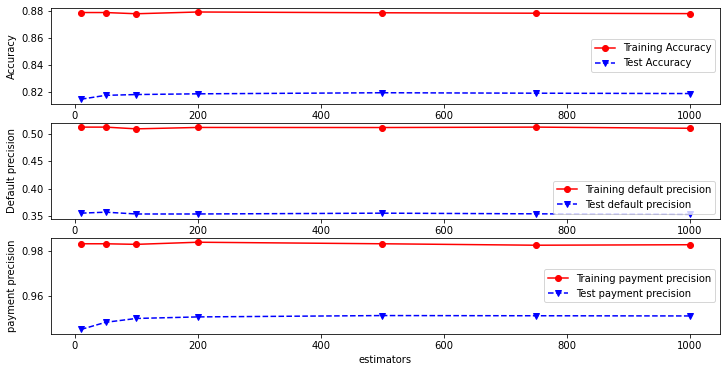

In [26]:
#Bootstrapping data, features stay the same, taking all features to bootstrap
bagging(True,False,1)

[0.8151333333333334, 0.8181333333333334, 0.8182666666666667, 0.8186666666666667, 0.8190666666666667, 0.8194, 0.8185333333333333]
[0.3547317661241712, 0.3511151295961423, 0.3541289933694997, 0.35171790235081374, 0.3541289933694997, 0.35563592525617843, 0.35171790235081374]
[0.945899674713234, 0.950778976202705, 0.9500941619585688, 0.9512925868858072, 0.9511213833247731, 0.9511213833247731, 0.9511213833247731]


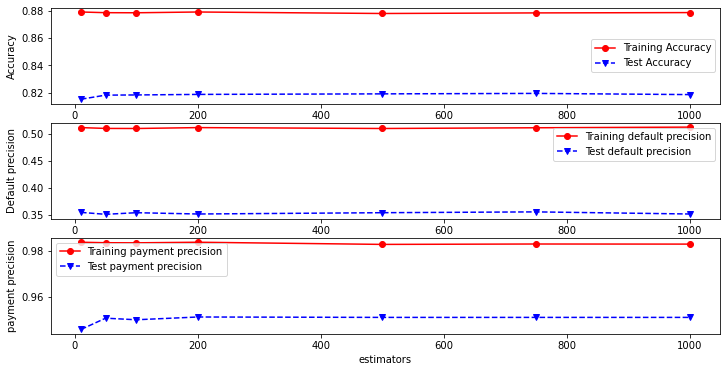

In [27]:
#Bootstrapping data, features stay the same, taking half features to bootstrap
bagging(True,False,0.5)

[0.8079333333333333, 0.8112, 0.814, 0.8166666666666667, 0.8174666666666667, 0.8168666666666666, 0.8156]
[0.29535864978902954, 0.2935503315250151, 0.31977094635322484, 0.3357444243520193, 0.3303194695599759, 0.33273056057866185, 0.32127787823990356]
[0.9535182331792501, 0.9582263311076871, 0.9543742509844205, 0.9532614278376991, 0.9558294812532101, 0.9543742509844205, 0.9560006848142442]


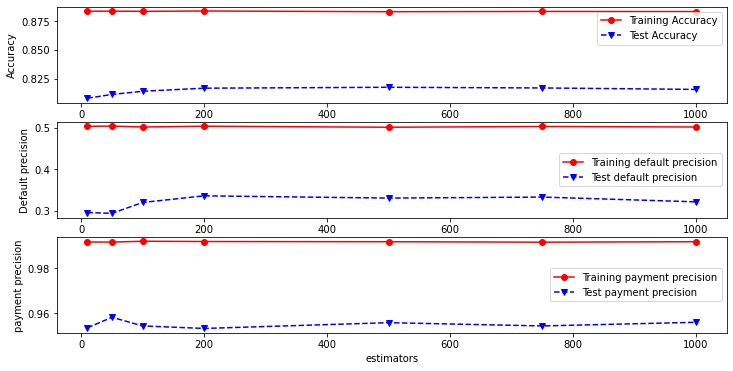

In [28]:
#Bootstrapping data, features bootstrapping, taking all features to bootstrap
bagging(True,True,1.0)

[0.8062666666666667, 0.8162, 0.8167333333333333, 0.8165333333333333, 0.815, 0.8169333333333333, 0.8155333333333333]
[0.2875226039783002, 0.3336347197106691, 0.3357444243520193, 0.3318264014466546, 0.3206751054852321, 0.32881253767329716, 0.32670283303194697]
[0.9536038349597672, 0.9532614278376991, 0.953347029618216, 0.9542030474233864, 0.9554014723506249, 0.955572675911659, 0.9543742509844205]


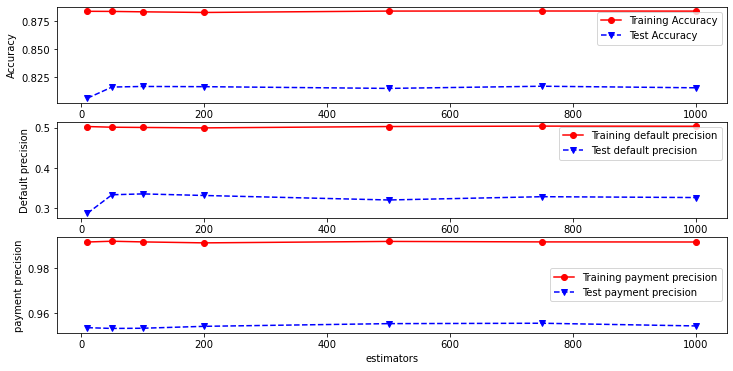

In [29]:
#Bootstrapping data, features bootstrapping, taking half features to bootstrap

bagging(True,True,0.5)

[0.8068666666666666, 0.8156666666666667, 0.8154666666666667, 0.8141333333333334, 0.8144, 0.8143333333333334, 0.8152666666666667]
[0.2962628089210368, 0.3378541289933695, 0.33484026522001203, 0.3294153104279687, 0.3270042194092827, 0.32338758288125374, 0.3294153104279687]
[0.9518917993494265, 0.9513781886663243, 0.9519774011299436, 0.9518061975689094, 0.9528334189351139, 0.9537750385208013, 0.9532614278376991]


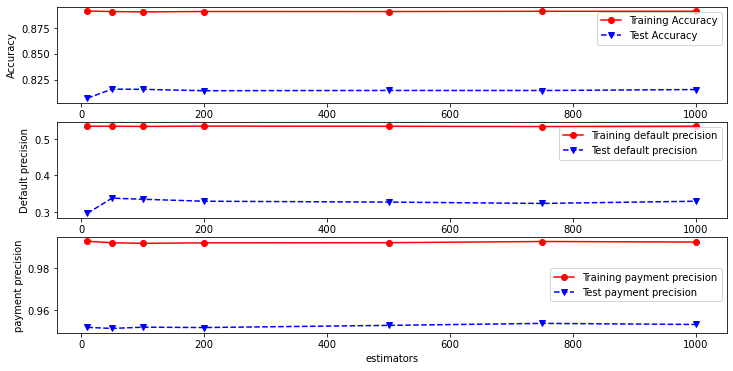

In [30]:
#not data, features bootstrapping, taking all features to bootstrap

bagging(False,True,1)

[0.8102666666666667, 0.8142666666666667, 0.8156666666666667, 0.8128666666666666, 0.8131333333333334, 0.815, 0.8152]
[0.3369499698613623, 0.3330319469559976, 0.3351416515973478, 0.3161543098251959, 0.32248342374924654, 0.3297166968053044, 0.3333333333333333]
[0.9447012497859956, 0.9509501797637391, 0.9521486046909776, 0.9539462420818353, 0.9524910118130457, 0.9528334189351139, 0.9520630029104605]


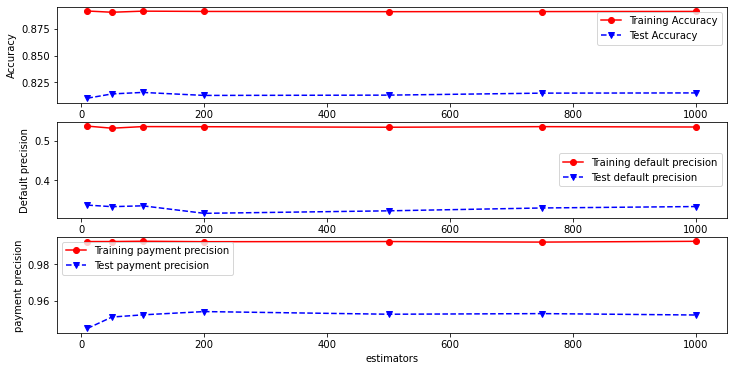

In [31]:
#not data, features bootstrapping, taking half features to bootstrap

bagging(False,True,0.5)

### Conclusions
<a id='bagging_con'></a>

Bagging is vary accurate in terms of the dominant class of payments which very good and and overall accuracy is good too therefore this is the best model so far and I will use this model to detect payment with 94%. But the precision for defaulters has suffered

# Final Conclusions

I conclude the model that is the best model for this data set among the models I have tested is the decision tree model with the use of either gini or entropy. This is prefered over the bagging model because the bagging model less precise to defaulters which is the goal of the model and also the penelty sufferd in the paynment group is tolerable compared to the other models. 

What I could try in another exploration time is the changing of the random seed to find the best model and and cycle through them. Also I could develop 3 ensamble models (e.g random forest, logistic regression and knn) and vote on the output like bagging. 

## Best model trained and tested

In [32]:
dt = tree.DecisionTreeClassifier(criterion='gini',max_depth=10,max_features='auto')
        
#Fitting model
dt.fit(x_train,y_train)
        #Creating predictions
pred = dt.predict(x_test)

print(accuracy_score(y_test,pred))
print(precision_score(pred,y_test))
print(precision_score(pred,y_test,pos_label=0))

0.8067333333333333
0.35322483423749246
0.9355418592706728
